In [26]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [27]:
def open_image(path):
    img = Image.open(path)
    img = img.convert("RGB")
    img = np.array(img)
    return img

def gen_mask(Re):
    # generate mask with the boundary conditions and RE encoded into the image
    mask = np.zeros((128, 128, 3), dtype=np.uint8)
    # mask is the Re number where min is 0 and max is 4000 scaled to 0-255
    encoded_RE_color = (int(Re / 4000 * 255), 255, 0)
    mask[:, :, :] = encoded_RE_color
    # walls on the left, right and bottom
    border_color = (255, 255, 255)
    mask[-1, :, :] = border_color # bottom
    mask[:, 0, :] = border_color # left
    mask[:, -1, :] = border_color # right
    return mask

def generate_input(Re, ts, mode='mask'):
    if mode == 'mask':
        img = gen_mask(Re)
    elif mode == 'u':
        img = open_image(f"../../data/{Re:.1f}/u_{ts:.2f}.png")
    elif mode == 'v':
        img = open_image(f"../../data/{Re:.1f}/v_{ts:.2f}.png")
    img = img.transpose(2, 0, 1)
    return img

In [28]:
RE = 100.
ts = 0.05

In [29]:
img_u = generate_input(RE, ts, 'u')
img_v = generate_input(RE, ts, 'v')
img_mask = generate_input(RE, ts, 'mask')
img_u.shape, img_v.shape, img_mask.shape

((3, 128, 128), (3, 128, 128), (3, 128, 128))

In [30]:
# use img_u[0], img_v[0] and img_mask[0] to get the first channel of the image (does not matter which one, since grayscale) and stack them into a single image
img = np.stack([img_u[0], img_v[0], img_mask[0]], axis=0)
img.shape

(3, 128, 128)

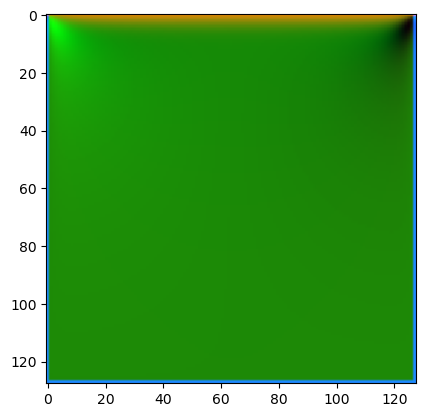

In [31]:
plt.imshow(img.transpose(1, 2, 0))

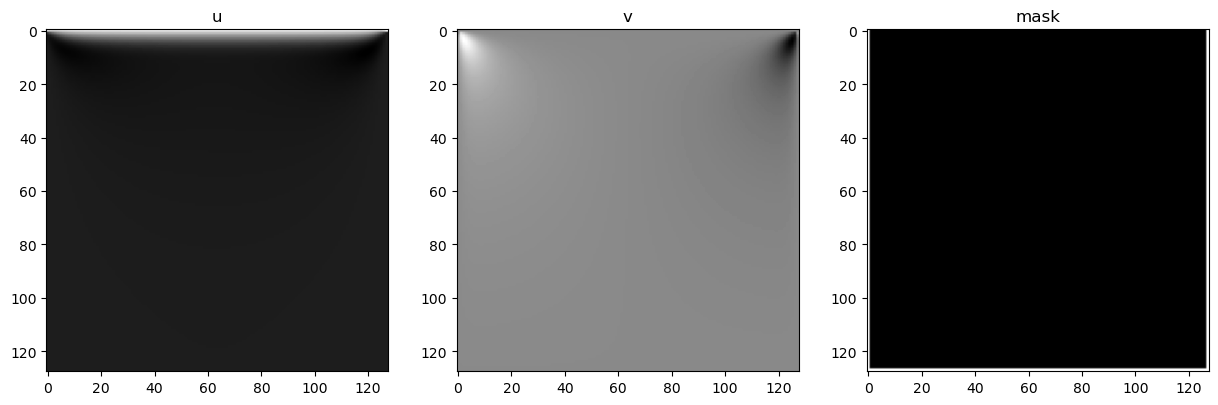

In [32]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img_u[0], cmap='gray')
ax[0].set_title('u')
ax[1].imshow(img_v[0], cmap='gray')
ax[1].set_title('v')
ax[2].imshow(img_mask[0], cmap='gray')
ax[2].set_title('mask')
plt.show()

# testing if changes in dataset worked

In [6]:
##################
#
# Bachelor Thesis: Deep learning based lid-driven cavity flow simulation with u-net CNN
# @author: Alexandru Schneider
# @supervisor: R.P. Mundani
# Computational and Data Science
# FHGR
#
##################

import os, sys, random
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.optim as optim

from UNet import UNet, weights_init
import dataset
import utils
import matplotlib.pyplot as plt

######## Settings ########

# number of training iterations
iterations = 100000
# batch size --> how many images are processed at once
batch_size = 3
# learning rate, generator
lrG = 0.0006
# decay learning rate?
decayLr = True
# channel exponent to control network size
expo = 3
# data set config
prop=None # by default, use all from "../data/train"
#prop=[1000,0.75,0,0.25] # mix data from multiple directories
# save txt files with per epoch loss?
saveL1 = False

plotFirstTrainSet = True

##########################

dropout    = 0.      # note, the original runs from https://arxiv.org/abs/1810.08217 used slight dropout, but the effect is minimal; conv layers "shouldn't need" dropout, hence set to 0 here.
doLoad     = ""      # optional, path to pre-trained model

print("LR: {}".format(lrG))
print("LR decay: {}".format(decayLr))
print("Iterations: {}".format(iterations))
print("Dropout: {}".format(dropout))

##########################

seed = random.randint(0, 2**32 - 1)
print("Random seed: {}".format(seed))
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

######## Data ########
print("\nLoading data...")
data = dataset.TrainDataset(prop, shuffle=1)
dataValidation = dataset.ValiDataset(data)
trainLoader = DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)
valiLoader = DataLoader(dataValidation, batch_size=batch_size, shuffle=False, drop_last=True) 
print("\nTraining batches: {}".format(len(trainLoader)))
print("Validation batches: {}".format(len(valiLoader)))

######## Setup ########
print("\nSetup Model...")
epochs = int(iterations / len(trainLoader) + 0.5)
model = UNet(channelExponent=expo, dropout=dropout)
# save model as onnx to show with netron
dummy_input = torch.randn(batch_size, 3, 128, 128)
torch.onnx.export(model, dummy_input, "model_dummy_data.onnx")
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("Initialized model with {} parameters\n".format(params))

# initialize weights and load model if necessary
model.apply(weights_init)
if len(doLoad)>0:
    model.load_state_dict(torch.load(doLoad))
    print("Loaded model "+doLoad)
    
# loss function
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=lrG, betas=(0.5, 0.999), weight_decay=0.0)

targets = Variable(torch.FloatTensor(batch_size, 3, 128, 128))
inputs  = Variable(torch.FloatTensor(batch_size, 3, 128, 128))

LR: 0.0006
LR decay: True
Iterations: 100000
Dropout: 0.0
Random seed: 3409174779

Loading data...

Training batches: 5040
Validation batches: 133

Setup Model...
Initialized model with 147555 parameters



Epoch 1/20
torch.Size([3, 3, 128, 128]) torch.Size([3, 3, 128, 128])


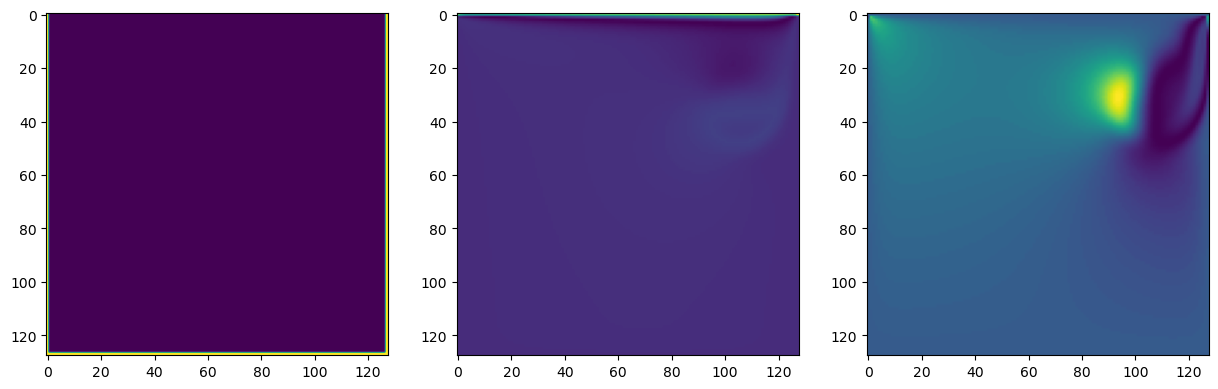

In [25]:
# train
import time
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    
    model.train()
    L1_accum = 0
    
    for i, train in enumerate(trainLoader, 0):
        inputs_cpu, targets_cpu = train
        inputs.data.copy_(inputs_cpu.float())
        targets.data.copy_(targets_cpu.float())
            
        print(inputs.shape, targets.shape)
        plotFirstTrainSet = False
        inputs_to_plot = [image.numpy().transpose(1, 2, 0) for image in inputs]
        targets_to_plot = [image.numpy().transpose(1, 2, 0) for image in targets]
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        one_image = inputs_to_plot[0]
        for i in range(3):
            ax[i].imshow(one_image[:, :, i])
        break
    break